In [1]:
import pandas as pd;
# from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import numpy as np
import collections
from collections import defaultdict
# import torchtext
import random;
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import torch
from transformers import *
import spacy
from ipywidgets import widgets
import torchtext
import math
import json
import glob
import csv

/export/scratch/petros/anaconda3/envs/testenv/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
import torch;
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

In [3]:
from scripts import *

In [4]:
annotated_file = "/export/scratch/saurav/kim/oct_20_new_data/dec_12_annotations.tsv"
output_folder = "/export/scratch/saurav/kim/scibert/jan_10/"
token_fite = "/export/scratch/petros/tokens"

In [5]:
annotated_data = pd.read_csv(annotated_file, sep='\t');
annotated_data = annotated_data.replace({np.nan: None})

In [6]:
indices = [];
labels = [];
cited_title_list = [];
citing_title_list = [];
cited_abstract_list = [];
citing_abstract_list = [];
citation_context_list = [];
for i in range(len(annotated_data.index)):
    if annotated_data['new annotation'][i] is None:
        if annotated_data['previous annotation'][i] is None:
            print("None", i)
            continue;
        label = str(annotated_data['previous annotation'][i]).strip().lower();
    else:
        label = str(annotated_data['new annotation'][i]).strip().lower();
    if label == 'used' or label == 'not used' or label == 'extended':
        labels.append(label);
        indices.append(i);
        cited_title_list.append(str(annotated_data.loc[i, 'cited title']))
        citing_title_list.append(str(annotated_data.loc[i, 'citing title']))
        cited_abstract_list.append(str(annotated_data.loc[i, 'cited abstract']))
        citing_abstract_list.append(str(annotated_data.loc[i, 'citing abstract']))
        # Since there multiple citation contexts, I've separated the with ---(j)--- in the spreadsheet, should ideally use regex to split them, here is a random way
        citing_contexts = str(annotated_data.loc[i, 'citation context']).split('---(1)---')[1].strip();
        temp_citation_context_list = [];
        j = 2;
        while True:
            citing_contexts = citing_contexts.split('---('+str(j)+')---');
            temp_citation_context_list.append(citing_contexts[0].strip());
            if len(citing_contexts) == 1:
                break;
            citing_contexts = citing_contexts[1].strip();
            j += 1;
        citation_context_list.append(temp_citation_context_list);
            
    else:
        print(label, i)
    

not sure 379


In [7]:
text_labels = labels
labels = [0]*len(text_labels);
for i in range(len(text_labels)):
    if text_labels[i]=='used':
        labels[i] = 1;

In [8]:
nlp = spacy.load('en_core_sci_lg', disable=["tagger", "parser", "textcat", "ner", "lemmatizer"])
#Note that we use r, gule-based segmenter, first I tried 'combined_rule_sentence_segmenter', 
# but that gave some errors, so followed the suggestions here: https://github.com/allenai/scispacy/issues/207
nlp.add_pipe('sentencizer')
# nlp.add_pipe(nlp.create_pipe('sentencizer'), first=True)

device = 'cuda'
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
config = BertConfig.from_pretrained('allenai/scibert_scivocab_uncased', output_hidden_states=True)
bert_model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased', config=config).to(device)

bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [9]:
def get_tokens(tokenizer, string):
    x = nlp(string);
    tokens = tokenizer(string ,return_tensors="pt", max_length=512)
    return tokens

In [10]:
def get_readout_index(tokens):
    cited_here_tokens = torch.tensor([962, 8412, 1530, 1374])
    readout_index = []
    
    l = tokens['input_ids'].size(1)
    for i in range(1, l - 4):
        if torch.equal(tokens['input_ids'][0, i:i+4], cited_here_tokens):
            readout_index.append(torch.arange(i, i+4))
    return torch.cat(readout_index)

def get_readout_mask(tokens, readout_index):
    mask = torch.zeros_like(tokens['input_ids'], dtype=torch.bool)
    mask[0, readout_index] = True
    return mask

def get_context_tokens(tokenizer, string):
    # get the tokens
    tokens = tokenizer(string ,return_tensors="pt", max_length=512, truncation=True)
    tokens['readout_mask'] = get_readout_mask(tokens, get_readout_index(tokens))
    return tokens

def readout(bert_result, readout_type, readout_mask=None, pooling=None):
    bert_dims = bert_result.last_hidden_state.size(-1)
    
    if readout_type == 'cls':
        return bert_result.last_hidden_state[0, 0]
    elif readout_type == 'mean':
        return bert_result.last_hidden_state[0].mean(0)
    elif readout_type == 'ch':
        if readout_mask is not None:
            result = bert_result.last_hidden_state[readout_mask].view(-1, 4, bert_dims).mean(1)
            if pooling == 'max':
                return result.max(0).values
            elif pooling == 'mean':
                return result.mean(0)
            elif pooling == 'sum':
                return result.sum(0)
            else:
                raise ValueError('Pooling {} is not supported.'.format(pooling))
        else:
            raise ValueError('Cited Here readout requires readout_index.')
    else:
        raise ValueError('Readout type {} is not supported.'.format(readout_type))

In [11]:
# # cited_title_bert = torch.zeros(len(cited_title_list), 768).float().to(device);
# # cited_abstract_bert = torch.zeros(len(cited_abstract_list), 768).float().to(device);
# # citing_title_bert = torch.zeros(len(citing_title_list), 768).float().to(device);
# # citing_abstract_bert = torch.zeros(len(citing_abstract_list), 768).float().to(device);
# # citation_context_bert = torch.zeros(len(context_mapping), 768).float().to(device);
# cited_title_token = []
# cited_abstract_token = []
# citing_title_token = []
# citing_abstract_token = []
# citation_context_token = []
# for i in range(len(cited_title_list)):
#     cited_title_token.append(get_tokens(tokenizer, cited_title_list[i]));
# for i in range(len(cited_abstract_list)):
#     cited_abstract_token.append(get_tokens(tokenizer, cited_abstract_list[i]));
# for i in range(len(citing_title_list)):
#     citing_title_token.append(get_tokens(tokenizer, citing_title_list[i]));
# for i in range(len(citing_abstract_list)):
#     citing_abstract_token.append(get_tokens(tokenizer, citing_abstract_list[i]));
# for i in range(len(citation_context_list)):
#     temp = []
#     for j in range(len(citation_context_list[i])):
#         temp.append(get_tokens(tokenizer, citation_context_list[i][j]));
#     citation_context_token.append(temp)

In [12]:
def mask_tokens(tokens, p=1.0):
    probability_matrix = torch.full(tokens['input_ids'].shape, p)
    mask = torch.bernoulli(probability_matrix).bool()
    
    # set special tokens to be True
    mask[0,0] = True
    mask[0,-1] = True
    if 'readout_mask' in tokens:
        mask[tokens['readout_mask']] = True
    
    tokens2 = dict()
    tokens2['input_ids'] = tokens['input_ids'][mask].unsqueeze(0) 
    tokens2['token_type_ids'] = tokens['token_type_ids'][mask].unsqueeze(0)
    tokens2['attention_mask'] = tokens['attention_mask'][mask].unsqueeze(0)
    if 'readout_mask' in tokens:
        tokens2['readout_mask'] = tokens['readout_mask'][mask].unsqueeze(0)
    
    return tokens2

In [13]:
cited_title_token = []
cited_abstract_token = []
citing_title_token = []
citing_abstract_token = []
citation_context_token = []
for i in range(len(cited_title_list)):
    cited_title_token.append(get_tokens(tokenizer, cited_title_list[i]));
for i in range(len(cited_abstract_list)):
    cited_abstract_token.append(get_tokens(tokenizer, cited_abstract_list[i]));
for i in range(len(citing_title_list)):
    citing_title_token.append(get_tokens(tokenizer, citing_title_list[i]));
for i in range(len(citing_abstract_list)):
    citing_abstract_token.append(get_tokens(tokenizer, citing_abstract_list[i]));
for i in range(len(citation_context_list)):
    temp = []
    for j in range(len(citation_context_list[i])):
        temp.append(get_context_tokens(tokenizer, citation_context_list[i][j]));
    citation_context_token.append(temp)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [14]:
# torch.save(cited_title_bert, os.path.join(output_folder, 'cited_title_tokens.tns'))
# torch.save(cited_abstract_bert, os.path.join(output_folder, 'cited_abstract_tokens.tns'))
# torch.save(citing_title_bert, os.path.join(output_folder, 'citing_title_tokens.tns'))
# torch.save(citing_abstract_bert, os.path.join(output_folder, 'citing_abstract_tokens.tns'))
# torch.save(citation_context_bert, os.path.join(output_folder, 'citation_context_tokens.tns'))


In [15]:
seed = 1209384752;
# seed = 1209384756
""" 1209384756"""
frac_list = [0.05*i for i in range(1, 20)];
num_runs = 100;
learning_rate = 5e-5;
lr1 = 0.0001;
lr2 = 0.0001;
lr3 = 0.0001;
lr4 = 0;
l2_regularization = 0.0001;
num_epochs = 100;
patience = 5;
batch_size = 8;
verbose = False;
hidden_dim = 4;
save_postfix = "mlp"
device = 'cuda'

In [16]:
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True

In [17]:
def get_splits(labels_list, train_seed=1029384756, train_fraction=0.7, test_seed=0):
    unique_labels = list(set(labels_list))
    indices_list = [];
    random.seed(test_seed);
    for i in range(len(unique_labels)):
        indices_list.append(np.array([_ for _ in range(len(labels_list)) if labels_list[_]==unique_labels[i]]));
        random.shuffle(indices_list[-1])
    
    train_indices, valid_indices, test_indices = [], [], [];
    
    for i in range(len(indices_list)):
        test_count = int(0.1 * len(indices_list[i]));
        test_indices.append(indices_list[i][:test_count]);
#         random.shuffle(indices_list[i][test_count:])
     
    
    random.seed(train_seed);
    for i in range(len(indices_list)):
        random.shuffle(indices_list[i][test_count:])
    
    for i in range(len(indices_list)):
        test_count = int(0.1* len(indices_list[i]));
        train_count = int(train_fraction*(len(indices_list[i]) - test_count));
        train_indices.append(indices_list[i][test_count:test_count+train_count]);
        valid_indices.append(indices_list[i][test_count+train_count:])
    
    train_indices = np.concatenate(train_indices);
    valid_indices = np.concatenate(valid_indices);
    test_indices = np.concatenate(test_indices);
    return train_indices, valid_indices, test_indices;

def get_majority_votes(scores, num_classifiers):
    final_scores = []
    off_by = []
    non_votes = 0
    for i in range(len(scores[0])):
        votes = [0,0]   
        for j in range(num_classifiers):
            if scores[j][i] >= 0.5:
                votes[0] += 1;
            elif scores[j][i] <= 0.5:
                votes[1] += 1;
            else:
                non_votes += 1;
                
        final_scores.append(np.argmax(votes));
        off_by.append(num_classifiers - votes[final_scores[-1]])
        
    return final_scores, off_by, non_votes;

In [18]:
print(citation_context_list[22])

['The sub-atmospheric pressure CO 2 adsorption isotherm at 273 K for SiC-DC1073 1 µm is predicted using the FWT model and the comparison between the Ar PSD-based predictions (excess theoretical adsorption isotherm) and the experimental data is shown in Figure 7 . For the predictions, the microstructure of the investigated SiC-DC samples is assumed to be rigid under this low pressure condition. CO 2 is treated as an effective Lennard-Jones (LJ) sphere for which the LJ parameters for the CO 2 -CO 2 interactions are taken from elsewhere <CITED HERE> . adsorption, the binary parameter value of k cf = 0 is used since the one-center assumption for CO 2 molecules is suitable at sub-atmospheric pressures [18] . It can be observed that the FWT model provides reasonably good agreement between the excess theoretical and experimental adsorption isotherm for the synthesized sample, indicating good approximation of the slitpore model for even very disordered carbons such as the SiC-DC. This has been

In [19]:
def tokens_to_cuda(tokens, device):
#     device = 'cuda'
    dictionary = {}
    for key, value in tokens.items():
        dictionary[key] = value.to(device)
    return dictionary

def get_batched_token(batch_indices, device, p=1.0 ):
    batched_cited_title = tokens_to_cuda(mask_tokens(cited_title_token[batch_indices],p), device)
    batched_cited_abstract = tokens_to_cuda(mask_tokens(cited_abstract_token[batch_indices],p), device)
    batched_citing_title = tokens_to_cuda(mask_tokens(citing_title_token[batch_indices],p), device)
    batched_citing_abstract = tokens_to_cuda(mask_tokens(citing_abstract_token[batch_indices],p), device)
#     batched_citation_context = tokens_to_cuda(citation_context_token[batch_indices], device)
    batched_citation_context = []
    for i in range(len(citation_context_token[batch_indices])):
        batched_citation_context.append(tokens_to_cuda(mask_tokens(citation_context_token[batch_indices][i],p), device))
    batched_labels = torch.LongTensor(labels)[batch_indices].unsqueeze(0).to(device);
    
    
    return (batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context, batched_labels)

In [20]:
class BertClassifier(nn.Module):
    
    def __init__(self, n_classes, bert, emb_dim, hidden_list, dropout=0.5, flag='mean',readout='ch', pooling='max'):
        super().__init__()        
        self.flag = flag
        self.n_classes = n_classes  
        self.n_layers = len(hidden_list)
        self.hidden_layers = nn.ModuleList([])
        self.batch_norm = nn.ModuleList([])
        input_ = emb_dim*5
        for i in range(len(hidden_list)):
            self.hidden_layers.append(nn.Linear(input_, hidden_list[i]));
            self.batch_norm.append(nn.BatchNorm1d(hidden_list[i]));
            input_ = hidden_list[i];
        self.top_layer = nn.Linear(hidden_list[-1], n_classes)
        self.dropout = nn.Dropout(dropout);
        self.scibert = bert;
        self.readout = readout;
        self.pooling = pooling;
    
    
    def forward(self, cited_title_token, cited_abstract_token, citing_title_token, citing_abstract_token, citation_context_token):
#         tuple
        cited_tilte = self.scibert(**cited_title_token)
        cited_abstract = self.scibert(**cited_abstract_token)
        citing_tilte = self.scibert(**citing_title_token)
        citing_abstract = self.scibert(**citing_abstract_token)
       
        citation_context = []
        for i in range(len(citation_context_token)):
            readout_index = citation_context_token[i].pop('readout_mask')
            citation_context.append(readout(self.scibert(**citation_context_token[i]), readout_type=self.readout, readout_mask=readout_index, pooling=self.pooling))

#             citation_context.append(self.scibert(**citation_context_token[i]).last_hidden_state[:,0])

        citation_context = torch.stack(citation_context, dim=0)
        if self.flag=='sum':
            citation_context = citation_context.sum(dim=0,keepdims=True)
        elif self.flag =='max':
            citation_context = citation_context.max(dim=0, keepdims=True)
        elif self.flag == 'mean':
            citation_context = citation_context.mean(dim=0, keepdims=True)    
        elif self.flag == 'topk':
            topk = citation_context.topk(10,dim=0, keepdims=True)    
            citation_context = topk[0].mean(dim=0, keepdims=True)
        else:
            pass
        
        input_emb = torch.cat([cited_abstract.last_hidden_state[:,0], citing_abstract.last_hidden_state[:,0], cited_abstract.last_hidden_state[:,0]*citation_context, citing_abstract.last_hidden_state[:,0]*citation_context, citation_context], dim=1)
        hidden = self.dropout(torch.tanh(self.hidden_layers[0](input_emb)))

        
        for i in range(self.n_layers - 1):
            hidden = self.dropout(torch.tanh(self.hidden_layers[i+1](hidden)))
        scores = self.top_layer(hidden)
        
    
        return scores 

In [21]:
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True

In [22]:

test_ensemble_scores = []
val_ensemble_scores = []
scores_for_roc = []
val_cutoffs = []

learning_rate = 0.0001;
hidden_list = [1024, 128, 8]
# hidden_list = [100]

test_roc_list = [];
test_loss_list = [];

train_loss_info = [];
train_roc_info = [];

valid_loss_info = [];
valid_roc_info = [];

test_loss_info = [];
test_roc_info = [];

val_plots = []
test_plots = []
train_plots = []
phase_brk = -0.5


for run in range(5):
    test_indices = []
    test_labels = []
    val_indices = []
    val_labels = []
    test_seed = np.random.randint(100) #1029384756
    train_indices, valid_indices, test_indices = get_splits(labels, run, 0.7, test_seed)
    print(test_indices)
    print(valid_indices)
    print(train_indices)
    # Declare the model. We'll use the shallow CBoW classifier or the one that has one hidden layer.
    model = BertClassifier(n_classes=2, bert=bert_model, emb_dim=768, hidden_list=hidden_list, dropout=0.5)   

    val_plot = []
    test_plot = []
    train_plot = []

    # Put the model on the device.
    model.to(device)
    class_weight = torch.FloatTensor([np.count_nonzero(np.array(labels) == _)+0.0 for _ in range(2)]).to(device)
    class_weight = (torch.max(class_weight)/class_weight)**1.0

    # Cross-entropy loss as usual, since we have a classification problem.
    loss_function = torch.nn.CrossEntropyLoss(weight=class_weight)

    # Adam optimizer. We can try to tune the learning rate to get a fast convergence while avoiding instability.
    #  optimizer = torch.optim.Adam([{'params' :  model.top_layer.parameters(), 'lr' : lr1}, {'params' :  model.hidden_layers.parameters(), 'lr' : lr2}, {'params' :  model.batch_norm.parameters(), 'lr' : lr3}, {'params' :  model.scibert.parameters(), 'lr' : lr4}])


    # We'll keep track of some indicators and plot them in the end.
    history = defaultdict(list)
 
    lrs = [[0.0001,0], [2e-5,2e-5]]
    repeats = [1,1]
    epochs = 25
    
    optimizer = torch.optim.Adam([{'params' :  model.top_layer.parameters(), 'lr' : 0}, {'params' :  model.hidden_layers.parameters(), 'lr' : 0}, {'params' :  model.batch_norm.parameters(), 'lr' : 0}, {'params' :  model.scibert.parameters(), 'lr' : 0}])

    for lr_i in range(len(lrs)):
        lr = lrs[lr_i]
        if lr_i == 0:
            model.eval()
            with torch.no_grad():
                val_scores = [];
                val_labels = [];
                for batch in valid_indices:
                    (batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context, batched_labels) = get_batched_token(batch, device);
                    scores = model(batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context)
                    val_scores.extend(F.softmax(scores, dim=1).detach().cpu().numpy().tolist())
                    val_labels.extend(batched_labels.cpu().numpy().tolist())
                val_loss = loss_function(torch.FloatTensor(val_scores).to(device), torch.LongTensor(val_labels).to(device)).item()
                val_macro_roc = roc_auc_score(np.array(val_labels), np.array(val_scores)[:,1])
                val_plot.append(val_macro_roc)

                train_scores = [];
                train_labels = [];
                for batch in train_indices:
                    (batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context, batched_labels) = get_batched_token(batch, device);
                    scores = model(batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context)
                    train_scores.extend(F.softmax(scores, dim=1).detach().cpu().numpy().tolist())
                    train_labels.extend(batched_labels.cpu().numpy().tolist())
                train_loss = loss_function(torch.FloatTensor(train_scores).to(device), torch.LongTensor(train_labels).to(device)).item()
                train_macro_roc = roc_auc_score(np.array(train_labels), np.array(train_scores)[:,1])
                train_plot.append(train_macro_roc)


                test_scores = [];
                test_labels = [];
                for batch in test_indices:
                    (batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context, batched_labels) = get_batched_token(batch, device);
                    scores = model(batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context)
                    test_scores.extend(F.softmax(scores, dim=1).detach().cpu().numpy().tolist())
                    test_labels.extend(batched_labels.cpu().numpy().tolist())
                test_loss = loss_function(torch.FloatTensor(test_scores).to(device), torch.LongTensor(test_labels).to(device)).item()
                test_macro_roc = roc_auc_score(np.array(test_labels), np.array(test_scores)[:,1])
                test_plot.append(test_macro_roc)

                print(train_macro_roc, test_macro_roc, val_macro_roc)


        print("using learning rate", lr)
        
#       optimizer = torch.optim.Adam([{'params' :  model.top_layer.parameters(), 'lr' : lr[0]}, {'params' :  model.hidden_layers.parameters(), 'lr' : lr[0]}, {'params' :  model.batch_norm.parameters(), 'lr' : lr[0]}, {'params' :  model.scibert.parameters(), 'lr' : lr[1]}])
    
        for g in optimizer.param_groups:
            g['lr'] = lr[0]
    
        optimizer.param_groups[-1]['lr'] = lr[1]
        
        early_stopping = EarlyStopping(patience=patience, verbose=verbose, save_path='/export/scratch/trash/bert_finetuning_checkpoint_{}.pt'.format(save_postfix))

        for g in optimizer.param_groups:
            print(g['lr'])

        
        for i in range(epochs):

            t0 = time.time()

            loss_sum = 0
            n_batches = 0

            # Calling model.train() will enable the dropout layers.
            model.train()
            # We iterate through the batches created by torchtext.
            # For each batch, we can access the text part and the output label part separately.

            train_scores = [];
            train_labels = [];

            np.random.shuffle(train_indices)
            for d in range(repeats[lr_i]):
                for offset in range(0,len(train_indices),batch_size):
                    loss = 0
                    bs = 0
                    for idx in range(batch_size):
                        b = offset+idx
                        if(b < len(train_indices)):
                            # Compute the output scores.
                            if d == 0:
                                (batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context, batched_labels) = get_batched_token(train_indices[b], device);
                            else:    
                                (batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context, batched_labels) = get_batched_token(train_indices[b], device, p= 1.0);
                            scores = model(batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context)
                            # Then the loss function.
                            loss += loss_function(scores, batched_labels)
                            bs += 1

                    loss = loss / (bs)

                    # Compute the gradient with respect to the loss, and update the parameters of the model.
                    optimizer.zero_grad()            
                    loss.backward()
                    optimizer.step()

                    loss_sum += loss.item()
                    n_batches += 1

                    train_scores.extend(F.softmax(scores, dim=1).detach().cpu().numpy().tolist())
                    train_labels.extend(batched_labels.cpu().numpy().tolist())
                    
#             train_pred_labs = [(round(s[1])) for s in train_scores]       
#             print(train_pred_labs)
            train_loss = loss_sum / n_batches
            print("End of epoch loss", train_loss)
            train_macro_roc = roc_auc_score(np.array(train_labels), np.array(train_scores)[:,1])
            history['train_loss'].append(train_loss)
            history['train_macro_roc'].append(train_loss)

            # After each training epoch, we'll compute the loss and accuracy on the validation set.
            n_correct = 0
            n_valid = len(valid_indices)
            loss_sum = 0
            n_batches = 0

            # Calling model.eval() will disable the dropout layers.
            model.eval()
            with torch.no_grad():
                val_scores = [];
                val_labels = [];
                for batch in valid_indices:
                    (batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context, batched_labels) = get_batched_token(batch, device);
                    scores = model(batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context)
                    val_scores.extend(F.softmax(scores, dim=1).detach().cpu().numpy().tolist())
                    val_labels.extend(batched_labels.cpu().numpy().tolist())
                val_loss = loss_function(torch.FloatTensor(val_scores).to(device), torch.LongTensor(val_labels).to(device)).item()
                val_macro_roc = roc_auc_score(np.array(val_labels), np.array(val_scores)[:,1])
                val_plot.append(val_macro_roc)

                train_scores = [];
                train_labels = [];
                for batch in train_indices:
                    (batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context, batched_labels) = get_batched_token(batch, device);
                    scores = model(batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context)
                    train_scores.extend(F.softmax(scores, dim=1).detach().cpu().numpy().tolist())
                    train_labels.extend(batched_labels.cpu().numpy().tolist())
                train_loss = loss_function(torch.FloatTensor(train_scores).to(device), torch.LongTensor(train_labels).to(device)).item()
                train_macro_roc = roc_auc_score(np.array(train_labels), np.array(train_scores)[:,1])
                train_plot.append(train_macro_roc)


                test_scores = [];
                test_labels = [];
                for batch in test_indices:
                    (batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context, batched_labels) = get_batched_token(batch, device);
                    scores = model(batched_cited_title, batched_cited_abstract, batched_citing_title, batched_citing_abstract, batched_citation_context)
                    test_scores.extend(F.softmax(scores, dim=1).detach().cpu().numpy().tolist())
                    test_labels.extend(batched_labels.cpu().numpy().tolist())
                test_loss = loss_function(torch.FloatTensor(test_scores).to(device), torch.LongTensor(test_labels).to(device)).item()
                test_macro_roc = roc_auc_score(np.array(test_labels), np.array(test_scores)[:,1])
                test_plot.append(test_macro_roc)
                print(train_macro_roc, test_macro_roc, val_macro_roc)

#             if i > 0:
#                 early_stopping(-val_macro_roc, model)
#                 if early_stopping.early_stop:
#                     if verbose:
#                         print('Early stopping!')
#                     break
    val_plots.append(val_plot) 
    test_plots.append(test_plot) 
    train_plots.append(train_plot) 
# torch.save(model.state_dict(), "/export/scratch/petros/test.pt")

[774  17 531  60 653 505 662 353 241 438  92 318 369 532 368  16  21 312
  43 320  30 597 480 244 330 627 537 545  40 217 794 111  36 482 740 630
 328  13 643 530 177 125 510 785   3 617 693 154 357 789 333 766 515 519
 275 282 205 703  96 467 623  24   9 687 304 521 240 298 578 400 358 114
 620 606 680 748 444 575 195]
[152 405 560  15 759 245 634 140 371 549 130  90 461 490 796 460 761 168
  65 611 319 324 669 317 226 415 603 619 166 350 640 413   1 123   6 383
  91  59 685 335 745 726 414 689 172 478 227 308 412  73 590 473 277 112
 556 550 425 186 202 752 782 229 758 151 484 145 148 672 741 450 652 544
 419 601  86 212 322 155 486 316 508 156 407 539 533 564 276 646 628 329
 171 377  10 701 216 792 750 128 778 469 538 349 665 518 389 270 481 801
 393   5 570 602 791 607 547   2 582 310 113 705 548 314 541 185 732 479
 509 498 108 656 692 250  66 101 554 720 751 296 605 673 299 770 586 100
 683 618 725 142 292 728 222 221 704 636 117 795  32 211  58 401 334 581
 440 246 638 210  82 

0.6650977198697069 0.7486559139784946 0.648784355179704
using learning rate [0.0001, 0]
0.0001
0.0001
0.0001
0
End of epoch loss 0.4606029652059078
0.9743159609120521 0.9798387096774193 0.9726920366455251
End of epoch loss 0.33009943016804755
0.9764983713355049 0.9818548387096774 0.9756871035940803
End of epoch loss 0.3000197554938495
0.9766123778501627 0.9838709677419355 0.977184637068358
End of epoch loss 0.30329311557579786
0.976400651465798 0.9838709677419355 0.9783298097251585
End of epoch loss 0.2671852378407493
0.976416938110749 0.9865591397849462 0.9797392529950669
End of epoch loss 0.2602258522529155
0.9781107491856678 0.9858870967741935 0.9804439746300211
End of epoch loss 0.24799839581828564
0.9789413680781759 0.9858870967741935 0.9792107117688513
End of epoch loss 0.20618834916967899
0.979201954397394 0.9845430107526882 0.9787702607470049
End of epoch loss 0.20627541246358305
0.9793648208469056 0.9858870967741935 0.9775369978858351
End of epoch loss 0.2062939964234829
0.979

End of epoch loss 0.5450345892459154
0.875700325732899 0.883736559139785 0.8359760394644116
End of epoch loss 0.49537073844112456
0.876400651465798 0.8850806451612904 0.8365045806906272
End of epoch loss 0.5358426226302981
0.8774755700325733 0.8938172043010753 0.8335976039464411
End of epoch loss 0.5140512380748987
0.8778338762214983 0.885752688172043 0.8360641296687809
End of epoch loss 0.49222090491093695
0.8766449511400651 0.8844086021505375 0.8363284002818887
End of epoch loss 0.5146526608150452
0.8781596091205213 0.8918010752688172 0.8350070472163496
End of epoch loss 0.5100394459441304
0.8778175895765472 0.894489247311828 0.8343023255813953
End of epoch loss 0.4942961379420012
0.8777687296416937 0.8877688172043011 0.8355355884425651
End of epoch loss 0.5128543158061802
0.8775244299674267 0.8891129032258065 0.8335976039464411
End of epoch loss 0.5170431898441166
0.8759609120521172 0.8797043010752688 0.8376497533474278
End of epoch loss 0.5030624938663095
0.8757491856677525 0.88104

End of epoch loss 0.34483049553819
0.9639820846905538 0.915994623655914 0.9645877378435519
End of epoch loss 0.3233070974238217
0.9654234527687297 0.9186827956989247 0.966261451726568
End of epoch loss 0.34089432284235954
0.9662540716612378 0.9193548387096775 0.9687279774489077
End of epoch loss 0.3100471047218889
0.9663843648208469 0.9173387096774194 0.9686398872445384
End of epoch loss 0.3070137567119673
0.9661807817589577 0.9274193548387096 0.9678470754052149
End of epoch loss 0.3138631535694003
0.9659609120521172 0.9206989247311828 0.9679351656095843
End of epoch loss 0.3000952817965299
0.965399022801303 0.9227150537634409 0.9677149400986611
End of epoch loss 0.30190419079735875
0.9672964169381106 0.9180107526881719 0.9668780831571528
End of epoch loss 0.2798076926264912
0.9663192182410423 0.9213709677419354 0.9677589852008457
End of epoch loss 0.2847747174091637
0.9669136807817589 0.9227150537634409 0.9656448202959831
End of epoch loss 0.27368956967256963
0.966628664495114 0.91935

End of epoch loss 0.25925662624649704
0.9699674267100977 0.9408602150537635 0.9567036645525018
End of epoch loss 0.24512271815910935
0.969299674267101 0.9435483870967742 0.9556465821000706
End of epoch loss 0.24010701361112297
0.9783550488599349 0.9448924731182795 0.957892882311487
End of epoch loss 0.23089396837167442
0.9769218241042344 0.9411962365591398 0.9556906272022552
End of epoch loss 0.2344013131223619
0.9794136807817589 0.9583333333333334 0.9585095137420718
End of epoch loss 0.2359592256252654
0.9810097719869706 0.9405241935483871 0.9547656800563777
End of epoch loss 0.22933859814656898
0.9819218241042345 0.9536290322580645 0.9581131078224102
End of epoch loss 0.2281720244209282
0.9844381107491856 0.9462365591397849 0.9521670190274842
End of epoch loss 0.23428590642288327
0.9835342019543974 0.9455645161290323 0.9541050035236083
End of epoch loss 0.2543717559892684
0.9774104234527687 0.9516129032258064 0.9596546863988724
End of epoch loss 0.2138609791873023
0.9818403908794788 

Text(0.5, 1.0, '1x training size with deletion rate 7.5% and CLS')

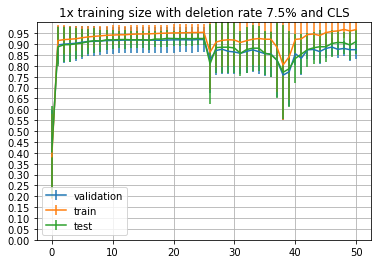

In [23]:


axes = plt.gca()
axes.set_ylim([0,1])

# plt.vlines(25,0,1)
plt.errorbar(x=range(len(test_plots[0])), y=np.mean(np.array(val_plots), axis=0)   , yerr=np.std(np.array(val_plots),axis=0) , label='validation')
plt.errorbar(x=range(len(test_plots[0])), y=np.mean(np.array(train_plots), axis=0), yerr=np.std(np.array(train_plots),axis=0) , label='train')
plt.errorbar(x=range(len(test_plots[0])), y=np.mean(np.array(test_plots), axis=0), yerr=np.std(np.array(test_plots),axis=0) , label='test')
plt.legend()
ax = plt.gca()
# ax.set_xticks(np.arange(0, 1, 0.))
ax.set_yticks(np.arange(0, 1., 0.05))

plt.grid()
plt.title("1x training size with deletion rate 7.5% and CLS")


In [24]:
# axes = plt.gca()
# axes.set_ylim([0,1])

# plt.vlines(phase_brk,0,1)
# plt.plot(val_plot, label='validation')
# plt.plot(train_plot,label='train')
# plt.plot(test_plot,label='test')
# plt.legend()
# print(len(val_plot))

In [25]:
# torch.save(model.state_dict(), "/export/scratch/petros/test.pt")

In [26]:
# model2 = BertClassifier(n_classes=2, bert=bert_model, emb_dim=768, hidden_list=hidden_list, dropout=0.5)   
# model2.load_state_dict(torch.load('/export/scratch/petros/test.pt'))